In [687]:
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt
import qutip as quit
from qutip import (about, basis, expect, mesolve, qeye, sigmax, sigmay, sigmaz, tensor, mcsolve)
from qutip.measurement import measure_observable, measurement_statistics
from qutip.expect import expect
from scipy.optimize import curve_fit
import matplotlib.gridspec as gridspec
#Add util to the path
import sys
sys.path.append('../util')
sys.path.append('../')

from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cm as cm
#import savgol:
from scipy.signal import savgol_filter
from fitting_functions_ZNE import third_no_first_ZNE, order_poly_ZNE, order_poly_instance, converge_ZNE_order, converge_ZNE_loocv

from qutip import (about, basis, expect, mesolve, qeye, sigmax, sigmay, sigmaz, tensor, mcsolve, sesolve, mesolve)
from basic_TFIM_funcs import get_s_lists
from joblib import Parallel, delayed
from functions_util import cetina_thermal_exp, cetina_envelope_exp,calibrate_sim_Omegas
from samplers_util import thermal_rejection

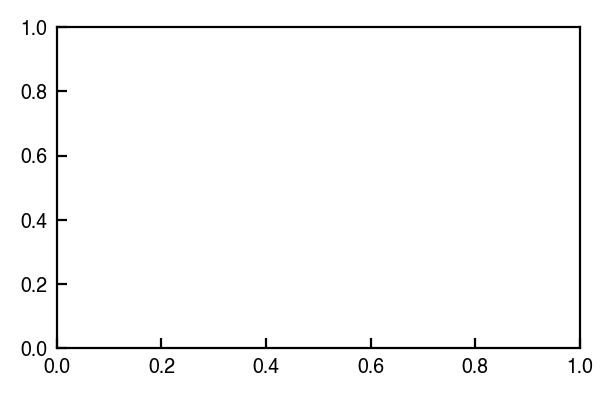

In [688]:
"""Figure includes Rabi oscillations for Gaussian noise, and regions for Rydberg and trapped ion error mechanisms. 
|---|--|
|   |  |
|-|-|--|
| | |  |
|-|-|--|
"""

#Create a matplotlib subplots in the layout above
import matplotlib as mpl
scol=(3+3/8) #single column width of PRL,
dcol=2*scol # double column,
fullwidth=6.3,
from matplotlib import cm
gr=(np.sqrt(5.0) - 1.0) / 2.0 #golden ratio,
cm_subsection = np.linspace(0.2, 1.0, 5)
Reds = [ cm.Reds(x) for x in cm_subsection ]
mpl.rcParams.update({
    "ytick.direction": "in",
    "xtick.direction": "in",
    "axes.labelpad": 0,
    "font.size": 7,
    "legend.frameon": False,
    "figure.dpi":200,
    "figure.figsize": [scol, scol * gr],
    "font.family": "Helvetica",
    #"axes.prop_cycle": cycler('color', palettable.colorbrewer.qualitative.Dark2_8.mpl_colors)
    # "axes.prop_cycle": cycler('color', palettable.colorbrewer.sequential.Reds_9.mpl_colors[1:])
})
fig = plt.figure()
gs = gridspec.GridSpec(1,1)  # 2x2 grid
ax_a = fig.add_subplot(gs[:])  # First row, first column
#x_bi = fig.add_subplot(gs[1, :4])  # First row, second column
#ax_bii = fig.add_subplot(gs[1, 4:8])  # First row, second column

#ax_c = fig.add_subplot(gs[0, 10:])  # First row, second column
#ax_di = fig.add_subplot(gs[1, 10:14])  # First row, second column
#ax_dii = fig.add_subplot(gs[1, 14:])  # First row, second

#ax_a = fig.add_subplot(221)
#ax_bi = fig.add_subplot(245)
#ax_bii = fig.add_subplot(246)
#ax_c = fig.add_subplot(222)
#ax_di = fig.add_subplot(247)
#ax_dii = fig.add_subplot(248)



#ax_bii.yaxis.tick_right()


#ax_a.set_xlabel(r'Time, ($\mathrm{ms}$)', usetex=1)
#ax_a.set_title('Two Qubit Interactions')
#ax_a.set_ylabel(r'$\langle Z_0 -Z_1 \rangle$')
#Axis b (i)


#ax_bi.set_xlabel(r'Noise Strength, ($\sigma$)')
##ax_bii.set_xlabel(r'Noise Strength, ($\sigma$)')
#ax_bi.set_ylabel(r'$\langle Z_0 -Z_1 \rangle$')
#ax_bii.set_yticks([])

#ax_c.set_title('Two Qubit Entanglement')
#ax_di.set_ylabel(r'Parity $\langle YYYY \rangle$')
#ax_dii.set_ylabel(r'Polarized Population')

#fig.tight_layout()
#plt.show()


In [689]:
#Create a PSD that loos like 1/w noise, fourier transform it into a signal, and plot it


In [690]:
import numpy as np
import matplotlib.pyplot as plt

# Set parameters for the signal
duration = 10  # Duration of the signal in seconds
sampling_rate = 1000  # Sampling rate in Hz (samples per second)
n_points = duration * sampling_rate  # Total number of points in the signal
time = np.linspace(0, duration, n_points)

# Generate 1/f noise in frequency domain and then convert to time domain
def generate_1_f_noise(n_points, sampling_rate):
    freqs = np.fft.fftfreq(n_points, d=1.0 / sampling_rate)
    freqs[0] = 1  # Avoid division by zero for DC component
    amplitudes = 2 / np.abs(freqs)**1.5  # 1/f distribution
    amplitudes[0] = 0  # Set DC component to zero
    # Increase amplitude of low frequency components
    #amplitudes = amplitudes * (1 + (1 / (1 + freqs**2)))
    random_phases = np.exp(1j * 2 * np.pi * np.random.rand(len(freqs)))
    noise_spectrum = amplitudes * random_phases
    noise_time_domain = np.fft.ifft(noise_spectrum).real
    return noise_time_domain

# Generate 1/f noise
time_domain_noise = generate_1_f_noise(n_points, sampling_rate)

# Add fast noise and a noise floor
fast_noise = 0.002 * np.random.normal(size=n_points)  # Fast varying noise
#noise_floor = 0.0  # Constant noise floor level

# Combine to create the final signal
signal = time_domain_noise + fast_noise#+ noise_floor

# Plot the resulting signal
ax_a.plot(time, signal, color='b', linewidth=.1)

# Define window parameters
window_duration = 0.1  # Duration of each window in seconds
window_spacing = 1.0  # Spacing between windows in seconds
window_samples = int(window_duration * sampling_rate)
spacing_samples = int(window_spacing * sampling_rate)

# Loop over windows and add bounding boxes and average indicators
for start_idx in range(0, n_points, spacing_samples):
    end_idx = start_idx + window_samples
    if end_idx > n_points:
        break
    avg_intensity = np.mean(signal[start_idx:end_idx])
    min_intensity = np.min(signal[start_idx:end_idx])
    max_intensity = np.max(signal[start_idx:end_idx])
    start_time = time[start_idx]
    end_time = time[end_idx]
    ax_a.axvspan(start_time, end_time, ymin=(min_intensity - ax_a.get_ylim()[0] - 0.005) / (ax_a.get_ylim()[1] - ax_a.get_ylim()[0]),
                 ymax=(max_intensity - ax_a.get_ylim()[0] + 0.005) / (ax_a.get_ylim()[1] - ax_a.get_ylim()[0]), color='orange', alpha=0.3, zorder=10, lw=0)
    ax_a.hlines(avg_intensity, start_time, end_time, colors='orange', linestyles='--', linewidth=2)
#print the average over the entire interval and the standard deviation:
print('The average of the signal is:', np.mean(signal))
print('The standard deviation of the signal is:', np.std(signal))


ax_a.set_xlabel(r'Time ($s$)')
ax_a.set_ylabel('Signal Amplitude')
#plt.title('Time Domain 1/f Noise with Noise Floor and Averages')
#plt.grid(True)
fig.tight_layout()
#save as .svg and .png low res
fig.savefig('1f_noise.svg')
fig.savefig('1f_noise.png', dpi=300)


The average of the signal is: -1.4608475625209661e-05
The standard deviation of the signal is: 0.006480745486685803
